In [1]:
import sys
import pandas as pd
import configparser
import numpy as np
import matplotlib.pyplot as plt
#from datetime import datetime
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

from data_helper import *
from IPython.display import display, HTML

Using TensorFlow backend.


In [2]:
config = configparser.ConfigParser()
config.read('config/mypredictorconfig.ini')

eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

look_back = int(config['MODEL']['look_back'])
anomaly_threshold = int(config['MODEL']['anomaly_threshold'])
forecast = config['MODEL']['forecast']

In [3]:
# Model reconstruction from JSON file
weight_name = config['infiles']['weight_name']
arch_name = config['infiles']['arch_name']
scaler = MinMaxScaler(feature_range=(0,1))
with open(arch_name, 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights(weight_name)

W0729 15:20:19.235723 4546762176 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 15:20:19.249584 4546762176 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 15:20:19.251977 4546762176 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 15:20:19.605010 4546762176 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name 

In [4]:
point_list = [point_name, 'aiTIT4045']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)
df.tail()

Grabbing WebIDs ...
WebID collection complete!
15:20:19: Sending API request... Chunk 1 of 1
15:20:19: Response recieved for 2 tags! (0.06)


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-29 10:00:00,3159.200582,78.079928
2019-07-29 11:00:00,3197.035339,80.916592
2019-07-29 12:00:00,3167.674103,83.784392
2019-07-29 13:00:00,3199.258596,86.552274
2019-07-29 14:00:00,3229.949046,89.282605


In [5]:
df1 = pc.get_stream_by_point('Future_TMY', end = forecast, interval = interval, calculation = calculation)#
df1.head()

Grabbing WebIDs ...
WebID collection complete!
15:20:19: Sending API request... Chunk 1 of 1
15:20:19: Response recieved for 1 tags! (0.04)


,Future_TMY
Timestamp,
2019-07-28 00:00:00,65.800003
2019-07-28 01:00:00,63.799999
2019-07-28 02:00:00,62.000000
2019-07-28 03:00:00,60.700001
2019-07-28 04:00:00,59.599998


In [6]:
new_df = pd.concat([df,df1], axis = 1, sort = False)
new_df.tail(6)

,GBSF_Electricity_Demand_kBtu,aiTIT4045,Future_TMY
Timestamp,,,
2019-07-29 14:00:00,3229.949046,89.282605,90.800003
2019-07-29 15:00:00,NaN,NaN,89.199997
2019-07-29 16:00:00,NaN,NaN,85.900002
2019-07-29 17:00:00,NaN,NaN,81.300003
2019-07-29 18:00:00,NaN,NaN,75.599998
2019-07-29 19:00:00,NaN,NaN,70.900002


In [7]:
new_df['aiTIT4045'].fillna(new_df.Future_TMY, inplace = True)
new_df.drop('Future_TMY', axis = 1, inplace = True)
new_df.head()

,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-17 00:00:00,2620.899984,66.328080
2019-07-17 01:00:00,2614.991353,64.489932
2019-07-17 02:00:00,2623.946960,63.002730
2019-07-17 03:00:00,2627.607707,62.071544
2019-07-17 04:00:00,2679.489187,61.753234


In [8]:
del df, df1
values_to_predict = new_df.loc[new_df[point_name].isna()].shape[0]
values_to_predict

5

In [9]:
def generate_prediction(df):
    y = df[point_name]
    X = df.drop(columns = point_name)
    X_test = scaler.fit_transform(X)
    y_test = scaler.fit_transform(np.array(y).reshape((-1,1)))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction.reshape(-1,1))
    index = df.index
    result = pd.DataFrame({"Actual":scaler.inverse_transform(y_test).reshape((-1,)),
                                   "Modeled":prediction.reshape((-1,))}, index=index)
    print("Predicted")
    #display(result.tail(2))
    print(result.Modeled.iloc[-1])
    print("-------------------------------------------")
    return result.tail(2)

In [10]:
firstNaN = new_df['aiTIT4045'].index.searchsorted(new_df[point_name].isna().idxmax())
firstNaN

303

In [11]:
for i in range(values_to_predict):
    
    #find the index of where the first nan appears in outside air temp
    nan_index = new_df['aiTIT4045'].index.searchsorted(new_df[point_name].isna().idxmax())
    #print(f"NaN index: {nan_index}")
    #create a DataFrame that has the tail of 10 points and has the first NaN value 
    #of point interested in as NaN
    df = new_df.iloc[ :nan_index + 1]
 
    
    df = create_standard_multivariable_df(df, shift = look_back, dropna = False)
    #drop all NaN values except the very last one as this is the 
    #one we are interested in predicting then append that last row
    #from df onto ddf
    ddf = df.iloc[:-1,:].dropna()
    ddf = ddf.append(df.iloc[-1], verify_integrity = True)

    result = generate_prediction(ddf)
    new_df.iloc[nan_index].fillna(result.Modeled.iloc[-1], inplace = True)

Predicted
3222.1274
-------------------------------------------
Predicted
3227.4612
-------------------------------------------
Predicted
3228.7397
-------------------------------------------
Predicted
3174.8064
-------------------------------------------
Predicted
3152.1055
-------------------------------------------


Text(0.5, 1.0, 'Predicting +5h')

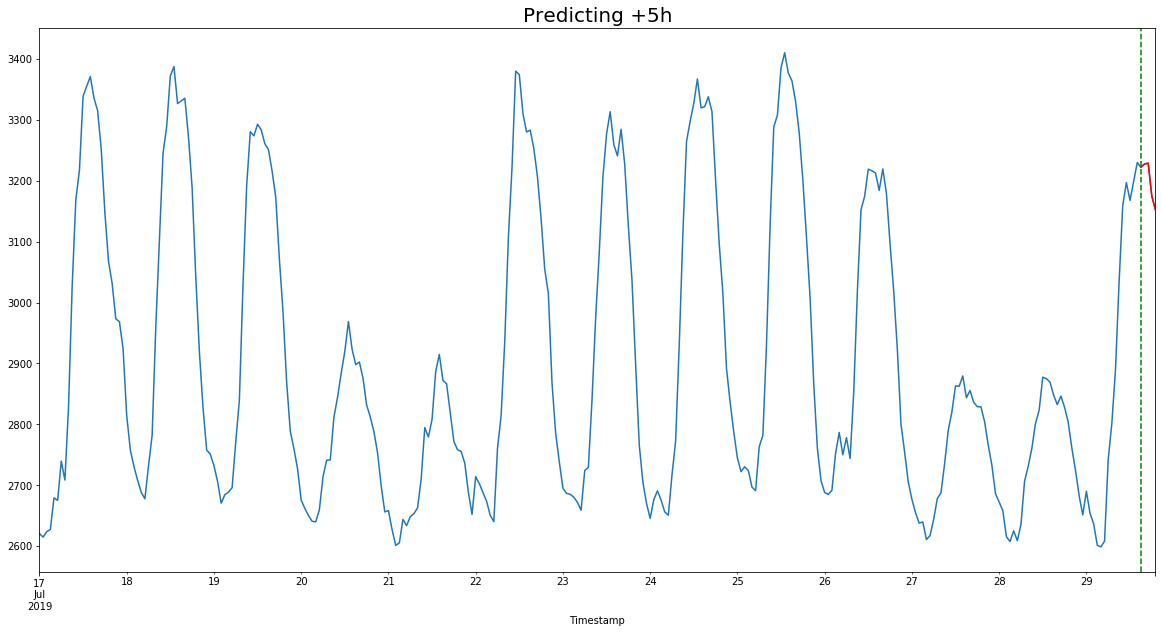

In [25]:
new_df[point_name].plot(figsize = (20,10))
new_df[point_name].iloc[firstNaN:].plot(figsize = (20,10), color = 'r')
plt.axvline(x = new_df.iloc[firstNaN].name, color = 'green', linestyle = '--')
plt.title(f"Predicting {forecast}", fontsize = 20)